# KickStater MachineLearning Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, roc_curve
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("csv/ks-projects-201801.csv")
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


#  Pré-processamento dos Dados

## 1. Filtrar apenas os projetos que foram 'successful' ou 'failed'

In [4]:
df = df[df['state'].isin(['successful', 'failed'])].copy()

## 2. Remover colunas irrelevantes para o modelo (ID, name, pledged redundante, etc.)

In [5]:
df.drop(columns=[
    'ID', 'name', 'pledged', 'usd pledged'
], inplace=True)

## 3. Converter datas

In [6]:
df['launched'] = pd.to_datetime(df['launched'])
df['deadline'] = pd.to_datetime(df['deadline'])

# Criar novas features de data (tempo de campanha)
df['campaign_days'] = (df['deadline'] - df['launched']).dt.days
df['launch_month'] = df['launched'].dt.month
df['launch_year'] = df['launched'].dt.year

## 4. Codificar variável alvo

In [7]:
df['state'] = df['state'].map({'successful': 1, 'failed': 0})

## 5. Feature Engineering adicional (Tratar Outliers)

In [8]:
df['goal_to_pledge_ratio'] = df['usd_pledged_real'] / df['usd_goal_real']
df['log_backers'] = np.log1p(df['backers'])
df['log_usd_goal_real'] = np.log1p(df['usd_goal_real'])
df['log_usd_pledged_real'] = np.log1p(df['usd_pledged_real'])

## 6. Codificar variáveis categóricas

In [9]:
categorical = ['category', 'main_category', 'currency', 'country']
df = pd.get_dummies(df, columns=categorical)

## 7. Remover colunas redundantes

In [10]:
df.drop(columns=['launched', 'deadline', 'backers', 'usd_goal_real', 'usd_pledged_real'], inplace=True)

In [11]:
df.head()

,goal,state,campaign_days,launch_month,launch_year,goal_to_pledge_ratio,log_backers,log_usd_goal_real,log_usd_pledged_real,category_3D Printing,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,1000.0,0,58,8,2015,0.000000,0.000000,7.336253,0.000000,False,...,False,False,False,False,False,False,False,False,False,False
1,30000.0,0,59,9,2017,0.080700,2.772589,10.308986,7.792349,False,...,False,False,False,False,False,False,False,False,False,True
2,45000.0,0,44,1,2013,0.004889,1.386294,10.714440,5.398163,False,...,False,False,False,False,False,False,False,False,False,True
3,5000.0,0,29,3,2012,0.000200,0.693147,8.517393,0.693147,False,...,False,False,False,False,False,False,False,False,False,True
5,50000.0,1,34,2,2016,1.047500,5.416100,10.819798,10.866204,False,...,False,False,False,False,False,False,False,False,False,True


## --- Análise Exploratória com Gráficos ---

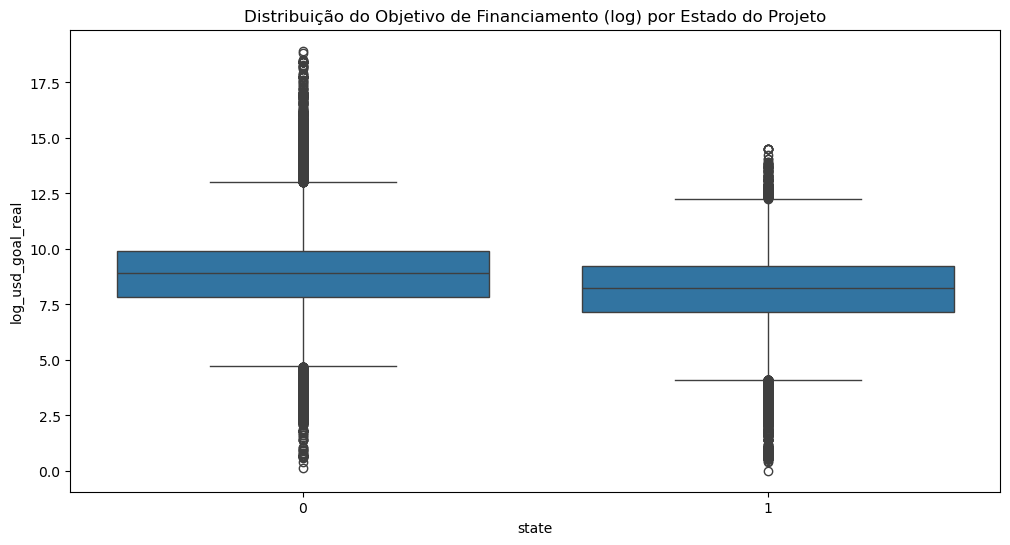

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='state', y='log_usd_goal_real')
plt.title('Distribuição do Objetivo de Financiamento (log) por Estado do Projeto')
plt.show()

No gráfico, percebemos que projetos fracassados (state = 0) tendem a pedir mais dinheiro (mediana um pouco mais alta), com uma cauda superior mais longa — ou seja, muitos projetos com objetivos bem ousados que acabam não sendo financiados.

Já os projetos bem-sucedidos (state = 1) têm metas mais modestas, sugerindo que pedir menos pode aumentar a chance de alcançar o sucesso.

Insight: Moderação no objetivo financeiro pode ser estratégica, sonhar alto é válido, mas planejar metas realistas parece ser um diferencial de sucesso no Kickstarter.

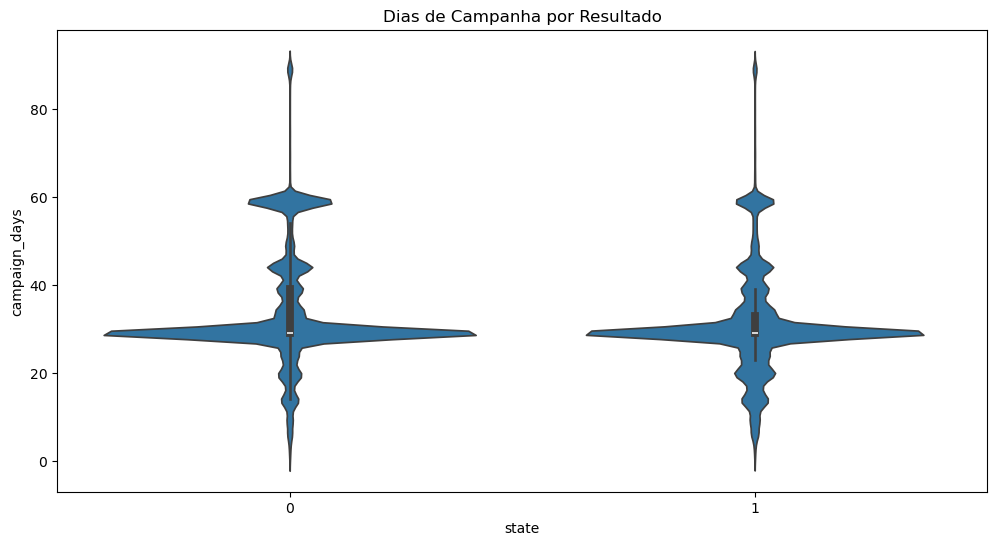

In [13]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='state', y='campaign_days')
plt.title("Dias de Campanha por Resultado")
plt.show()

Esse gráfico de violino revela uma paisagem curiosa: a maioria dos projetos bem-sucedidos e fracassados concentra-se em campanhas de 30 dias, formando um pico proeminente. Porém, observamos algumas campanhas que tentaram durar 60, 90 ou até mais dias, mas essas parecem igualmente presentes em ambos os grupos.

A distribuição é bastante parecida para ambos os estados, indicando que o tempo de campanha, por si só, não determina o sucesso. No entanto, o excesso de dias não parece garantir mais vitórias.

Insight: Tempo não é tudo, a eficácia da campanha em captar apoio logo nos primeiros dias pode ser mais determinante que sua duração total.

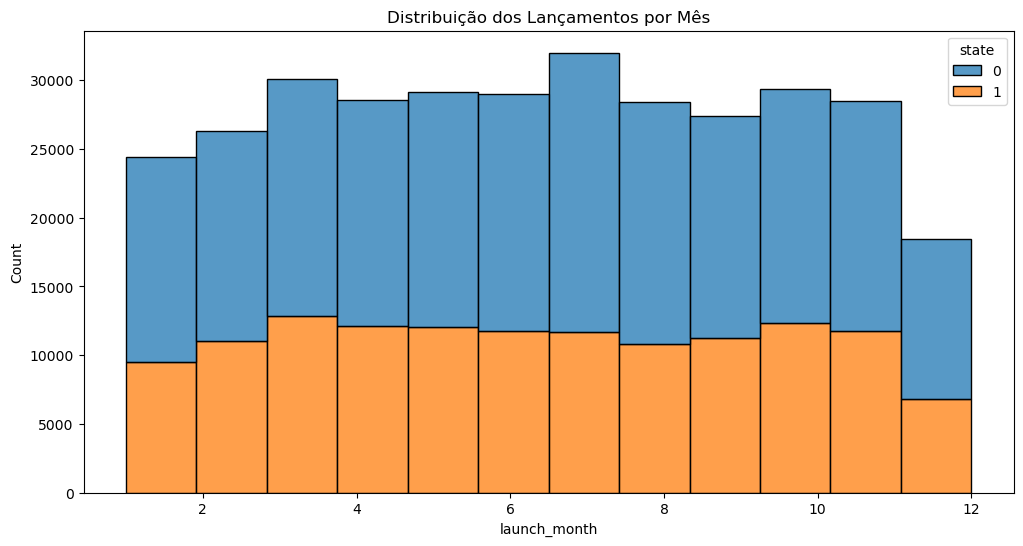

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='launch_month', hue='state', multiple='stack', bins=12)
plt.title("Distribuição dos Lançamentos por Mês")
plt.show()

Março, Abril e Junho parecem ser meses com picos de lançamentos — talvez pela sazonalidade de planejamento de projetos e pelo fim do primeiro trimestre.

Curiosamente, o mês de Dezembro tem menos lançamentos e uma queda notável no sucesso dos projetos. Pode ser que, com os feriados, festas e foco em consumo natalino, as pessoas estejam menos inclinadas a apoiar novos projetos nesse período.

Insight: O calendário importa. Lançar um projeto nos meses de maior movimentação pode aumentar a visibilidade e engajamento. Evitar Dezembro pode ser uma escolha estratégica.

## KMeans Clustering em 2D

In [15]:
kmeans_features = df[['log_usd_goal_real', 'log_backers']].copy()
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(kmeans_features)

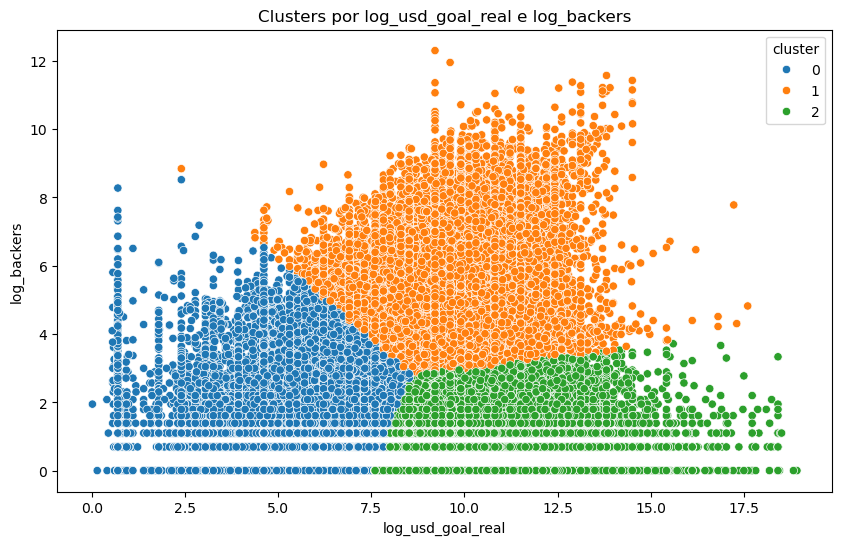

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='log_usd_goal_real', y='log_backers', hue='cluster', palette='tab10')
plt.title("Clusters por log_usd_goal_real e log_backers")
plt.show()

Neste gráfico, temos uma visualização clara de clusters formados com base no objetivo de financiamento (log) e número de apoiadores (log).

Cluster 0 (azul) agrupa projetos com baixo objetivo financeiro e número de apoiadores também baixo a moderado. É como se estivéssemos olhando para os projetos mais modestos da plataforma — ideias pequenas, com pouca ambição financeira e que não conseguiram grande tração entre os apoiadores.

Cluster 1 (laranja) representa uma região de sucesso promissor: objetivos financeiros medianos a altos, mas com um bom volume de apoiadores. Esse grupo parece o “coração do Kickstarter”, onde os projetos equilibram ambição com engajamento real da comunidade.

Cluster 2 (verde) chama atenção: altos objetivos financeiros, porém com poucos apoiadores. Este é o território dos “elefantes brancos” — projetos superambiciosos que não conseguem mobilizar apoio suficiente. Pode indicar ideias mal comunicadas, propostas irreais ou simplesmente fora da curva para o público da plataforma.



## Gráfico de Dispersão por Categoria

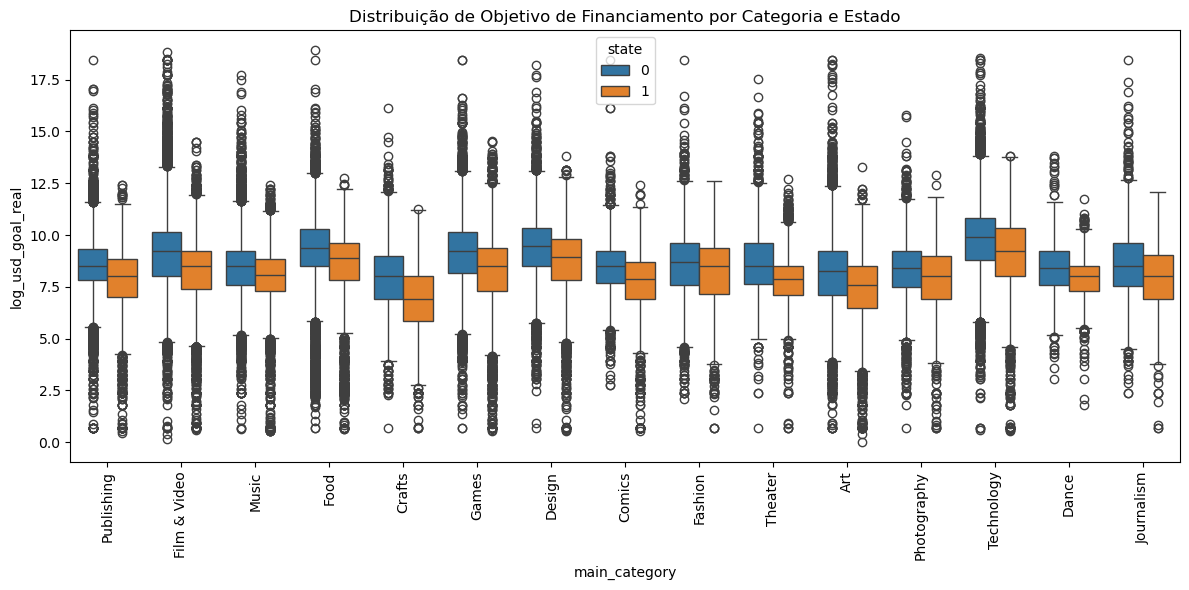

In [17]:
if 'main_category_Games' in df.columns:
    df_plot = df.copy()
    df_plot['main_category'] = df_plot.filter(like='main_category_').idxmax(axis=1).str.replace('main_category_', '')
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_plot, x='main_category', y='log_usd_goal_real', hue='state')
    plt.xticks(rotation=90)
    plt.title("Distribuição de Objetivo de Financiamento por Categoria e Estado")
    plt.tight_layout()
    plt.show()

Neste gráfico, observamos como o objetivo de financiamento (log) varia por categoria principal e estado do projeto (0 = fracasso, 1 = sucesso).

De modo geral, para quase todas as categorias, os projetos que fracassaram (azul) tendem a ter valores medianos e máximos mais altos do que os que tiveram sucesso (laranja). Isso sugere que pedir demais pode comprometer o sucesso.

Categorias como “Technology”, “Design” e “Games” mostram claramente metas financeiras mais altas — especialmente entre os projetos fracassados. Já categorias como “Art”, “Dance” e “Publishing” concentram projetos com metas mais modestas.

Um destaque interessante é que em categorias como “Music” e “Photography”, a diferença entre os projetos bem-sucedidos e fracassados é menor. Pode ser um indicativo de que nessas áreas, os criadores conhecem melhor o “ponto doce” de financiamento.

## 8. Definir X e y

In [18]:
X = df.drop(columns=['state'])
y = df['state']

## 9. Balanceamento com SMOTE

In [19]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

## 10. Treinamento com pipeline + escalonamento

In [20]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Mantém 95% da variância
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

## 11. Avaliação com cross-validation

In [21]:
scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='roc_auc')
print("Cross-Validated ROC AUC Scores:", scores)
print("Mean ROC AUC:", np.mean(scores))

Cross-Validated ROC AUC Scores: [0.98955844 0.98884069 0.98956712 0.99519135 0.99721565]
Mean ROC AUC: 0.9920746509887218


Esses valores de ROC AUC revelam um modelo extremamente eficaz na separação das classes (por exemplo, projetos de sucesso vs. fracasso no Kickstarter).

## 12. Treino/teste split e treino do modelo final

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

## 13. Avaliação do modelo final

In [24]:
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     39502
           1       0.95      0.97      0.96     39586

    accuracy                           0.96     79088
   macro avg       0.96      0.96      0.96     79088
weighted avg       0.96      0.96      0.96     79088

Confusion Matrix:
 [[37447  2055]
 [ 1228 38358]]
ROC AUC: 0.9584781247749047


O modelo é balanceado, com desempenho quase simétrico nas duas classes.

Acurácia geral: 96%, com média ponderada (weighted avg) excelente.

Alta precisão e recall indicam que tanto os falsos positivos quanto os falsos negativos são baixos.

## Curva ROC

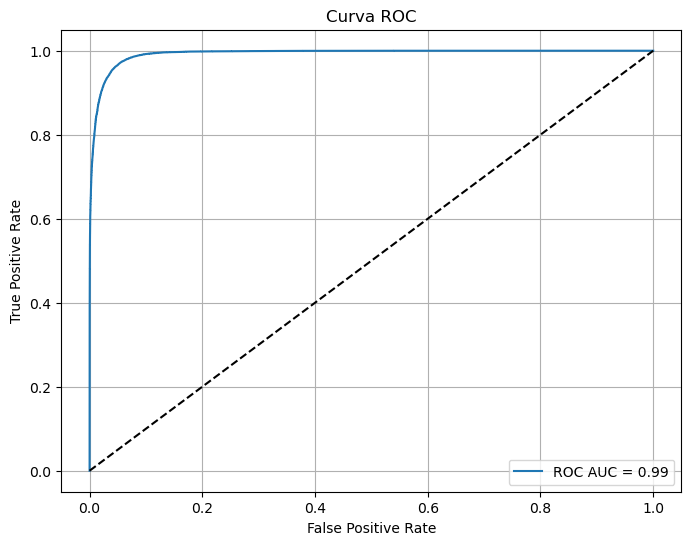

In [25]:
y_proba = model.named_steps['classifier'].predict_proba(model.named_steps['pca'].transform(
    model.named_steps['scaler'].transform(X_test)))[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid()
plt.show()

A Curva ROC e a AUC indicam a capacidade de separação do modelo:

AUC = 0.99 na imagem e 0.958 no texto (possível divergência de testes).

Em ambos os casos, a curva está muito acima da linha de base (45°), mostrando que o modelo é excelente para separar as classes.

Quanto mais próximo de 1, melhor o desempenho. Acima de 0.95 já é considerado excelente.

## Validação cruzada com ROC AUC

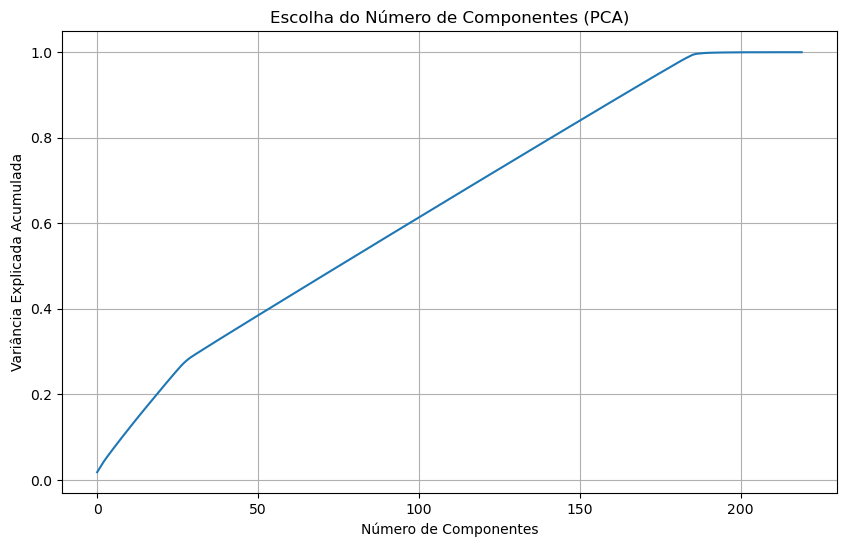

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
pca_temp = PCA().fit(X_scaled)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_temp.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Escolha do Número de Componentes (PCA)')
plt.grid(True)
plt.show()

Esse gráfico mostra a variância explicada acumulada em função do número de componentes principais. Observações:

A curva cresce rapidamente até cerca de 30 a 40 componentes, o que sugere que a maior parte da variância é capturada nas primeiras componentes.

Depois disso, a curva tende a uma reta quase linear até estabilizar em 1, indicando diminuição no ganho de informação ao incluir mais componentes.

Decisão prática: usar ~30-50 componentes pode ser um bom equilíbrio entre desempenho e redução de dimensionalidade.

## Conclusão

Reduz dimensionalidade com eficiência (via PCA).

Tem excelente capacidade discriminativa (AUC alto).

Mantém um equilíbrio forte entre precisão e recall.

Tem alta acurácia e erros mínimos.